In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os
os.chdir("/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/privacy/")
from privacy.encode import encodeNonAnonData
os.chdir("/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/")

In [2]:
data = "texas"
k_list = [2, 3, 4, 5]
degrees = [1, 2, 3]

In [3]:
_, X_test, y_test = encodeNonAnonData(data, f"/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/data/{data}/test.csv")

Replacing all generalized values...


14815it [00:00, 25910.18it/s]


In [4]:
test_accs_nhs = {}
for i in range(len(k_list)):
    model = tf.keras.models.load_model(f"./weights/model_{data}_{k_list[i]}.h5")
    res = model.evaluate(X_test, y_test, verbose=0)
    test_accs_nhs[f"K = {k_list[i]}"] = res
print(test_accs_nhs)

2023-12-15 21:58:25.841854: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-15 21:58:25.842179: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-12-15 21:58:26.224852: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-12-15 21:58:26.275087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-15 21:58:28.382457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-15 21:58:30.388918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-15 21:58:32.757168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


{'K = 2': 1.2445273399353027, 'K = 3': 1.5613652467727661, 'K = 4': 1.9266307353973389, 'K = 5': 1.8172292709350586}


In [5]:
test_accs_syb = {}
for i in range(len(degrees)):
    model = tf.keras.models.load_model(f"./syn_weights/model_{data}_{degrees[i]}.h5")
    res = model.evaluate(X_test, y_test, verbose=0)
    test_accs_syb[f"D = {degrees[i]}"] = res
print(test_accs_syb)

2023-12-15 21:58:35.027102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-15 21:58:38.545277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-15 21:58:41.968205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


{'D = 1': 0.8628945350646973, 'D = 2': 0.8745187520980835, 'D = 3': 0.7941076159477234}


In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from anonymeter.evaluators import SinglingOutEvaluator
from anonymeter.evaluators import LinkabilityEvaluator
from anonymeter.evaluators import InferenceEvaluator

In [7]:
ori = pd.read_csv("./data/texas/train.csv", sep=';')
# syn = pd.read_csv("./synthetic_results/texas_syn_2.csv", sep=';')
control = pd.read_csv("./data/texas/test.csv", sep=';')

In [8]:
ori.drop(["ID"], axis=1, inplace=True)
# syn.drop(["ID"], axis=1, inplace=True)
control.drop(["ID"], axis=1, inplace=True)

In [30]:
singlingout_risk_nhs = {}
for k in k_list:
    syn = pd.read_csv(f"./nhs_results/texas_anonymized_{k}.csv", sep=';')
    syn.drop(["ID"], axis=1, inplace=True)

    evaluator = SinglingOutEvaluator(ori=ori, 
                                 syn=syn, 
                                 control=control,
                                 n_attacks=1000)

    try:
        evaluator.evaluate(mode='univariate')
        singlingout_risk_nhs[f"K = {k}"] = evaluator.risk().value

    except RuntimeError as ex: 
        print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
            "For more stable results increase `n_attacks`. Note that this will "
            "make the evaluation slower.")

Attack `univariate` could generate only 2839 singling out queries out of the requested 10000. This can probably lead to an underestimate of the singling out risk.
Attack `univariate` could generate only 2281 singling out queries out of the requested 10000. This can probably lead to an underestimate of the singling out risk.
Attack `univariate` could generate only 1981 singling out queries out of the requested 10000. This can probably lead to an underestimate of the singling out risk.
Attack `univariate` could generate only 1800 singling out queries out of the requested 10000. This can probably lead to an underestimate of the singling out risk.


In [31]:
singlingout_risk_nhs

{'K = 2': 0.0, 'K = 3': 0.0, 'K = 4': 0.0, 'K = 5': 0.0}

In [32]:
singlingout_risk_nhs = {}
for k in k_list:
    syn = pd.read_csv(f"./nhs_results/texas_anonymized_{k}.csv", sep=';')
    syn.drop(["ID"], axis=1, inplace=True)

    evaluator = SinglingOutEvaluator(ori=ori, 
                                 syn=syn, 
                                 control=control,
                                 n_attacks=10000,
                                 n_cols=len(syn.columns))

    try:
        evaluator.evaluate(mode='multivariate')
        singlingout_risk_nhs[f"K = {k}"] = evaluator.risk().value

    except RuntimeError as ex: 
        print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
            "For more stable results increase `n_attacks`. Note that this will "
            "make the evaluation slower.")

KeyboardInterrupt: 

In [ ]:
singlingout_risk_nhs

{'K = 2': 0.0, 'K = 3': 0.0, 'K = 4': 0.0, 'K = 5': 0.0}

In [33]:
singlingout_risk_syn = {}
for d in degrees:
    syn = pd.read_csv(f"./synthetic_results/texas_syn_{d}.csv", sep=';')
    syn.drop(["ID"], axis=1, inplace=True)

    evaluator = SinglingOutEvaluator(ori=ori, 
                                 syn=syn, 
                                 control=control,
                                 n_attacks=10000,
                                 n_cols=len(syn.columns))

    try:
        evaluator.evaluate(mode='univariate')
        singlingout_risk_syn[f"D = {d}"] = evaluator.risk().value

    except RuntimeError as ex: 
        print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
            "For more stable results increase `n_attacks`. Note that this will "
            "make the evaluation slower.")

/Users/amirrezasokhankhosh/mambaforge/envs/data-science/lib/python3.10/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.00019199918533829787, baseline = 0.0006918071861529596. Analysis results cannot be trusted.
  self._sanity_check()
/Users/amirrezasokhankhosh/mambaforge/envs/data-science/lib/python3.10/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.0002919607855012302, baseline = 0.00039192238566416256. Analysis results cannot be trusted.
  self._sanity_check()
/Users/amirrezasokhankhosh/mambaforge/envs/data-science/lib/python3.10/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.00019199918533829787, baseline = 0.0006918071861529596. Analysis results cannot be trusted.
  self._sanity_check()


In [34]:
singlingout_risk_syn

{'D = 1': 0.0, 'D = 2': 0.0, 'D = 3': 0.0}

In [ ]:
singlingout_risk_syn = {}
for d in degrees:
    syn = pd.read_csv(f"./synthetic_results/texas_syn_{d}.csv", sep=';')
    syn.drop(["ID"], axis=1, inplace=True)

    evaluator = SinglingOutEvaluator(ori=ori, 
                                 syn=syn, 
                                 control=control,
                                 n_attacks=10000,
                                 n_cols=len(syn.columns))

    try:
        evaluator.evaluate(mode='multivariate')
        singlingout_risk_syn[f"D = {d}"] = evaluator.risk().value

    except RuntimeError as ex: 
        print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
            "For more stable results increase `n_attacks`. Note that this will "
            "make the evaluation slower.")

In [ ]:
singlingout_risk_syn

Index(['DISCHARGE', 'TYPE_OF_ADMISSION', 'PAT_STATE', 'PAT_STATUS', 'SEX_CODE',
       'RACE', 'ETHNICITY', 'ADMIT_WEEKDAY', 'PAT_AGE', 'RISK_MORTALITY',
       'ILLNESS_SEVERITY', 'LENGTH_OF_STAY', 'TOTAL_CHARGES'],
      dtype='object')

In [10]:
from tqdm import tqdm

In [19]:
linkability_risk_nhs = {}
aux_cols = [
        ['DISCHARGE', 'TYPE_OF_ADMISSION', 'PAT_STATUS', 'ADMIT_WEEKDAY', 'RISK_MORTALITY', 'ILLNESS_SEVERITY', 'LENGTH_OF_STAY'],
        ['PAT_STATE', 'SEX_CODE', 'RACE', 'ETHNICITY', 'PAT_AGE']
    ]
for r in tqdm(range(100)):
    for k in k_list:
        syn = pd.read_csv(f"./nhs_results/texas_anonymized_{k}.csv", sep=';')
        syn.drop(["ID"], axis=1, inplace=True)

        evaluator = LinkabilityEvaluator(ori=ori, 
                                        syn=syn, 
                                        control=control,
                                        n_attacks=10000,
                                        aux_cols=aux_cols,
                                        n_neighbors=10)

        evaluator.evaluate(n_jobs=-2) 
        if r == 0: # n_jobs follow joblib convention. -1 = all cores, -2 = all execept one
            linkability_risk_nhs[f"K = {k}"] = evaluator.risk().value
        else:
            linkability_risk_nhs[f"K = {k}"] += evaluator.risk().value
for k in k_list:
    linkability_risk_nhs[f"K = {k}"] = linkability_risk_nhs[f"K = {k}"] / 100

100%|██████████| 100/100 [35:09<00:00, 21.09s/it]


In [18]:
linkability_risk_nhs = {'K = 2': 0.0009477383577149823,
 'K = 3': 0.0009752765980252897,
 'K = 4': 0.0012244702725445718,
 'K = 5': 0.0011183417002245987}

In [20]:
linkability_risk_syn = {}
aux_cols = [
        ['DISCHARGE', 'TYPE_OF_ADMISSION', 'PAT_STATUS', 'ADMIT_WEEKDAY', 'RISK_MORTALITY', 'ILLNESS_SEVERITY', 'LENGTH_OF_STAY'],
        ['PAT_STATE', 'SEX_CODE', 'RACE', 'ETHNICITY', 'PAT_AGE']
    ]
for r in tqdm(range(100)):
    for d in degrees:
        syn = pd.read_csv(f"./synthetic_results/texas_syn_{d}.csv", sep=';')
        syn.drop(["ID"], axis=1, inplace=True)

        evaluator = LinkabilityEvaluator(ori=ori, 
                                        syn=syn, 
                                        control=control,
                                        n_attacks=1000,
                                        aux_cols=aux_cols,
                                        n_neighbors=10)

        evaluator.evaluate(n_jobs=-2)  # n_jobs follow joblib convention. -1 = all cores, -2 = all execept one
        if r == 0:
            linkability_risk_syn[f"D = {d}"] = evaluator.risk().value
        else:
            linkability_risk_syn[f"D = {d}"] += evaluator.risk().value
for d in degrees:
    linkability_risk_syn[f"D = {d}"] = linkability_risk_syn[f"D = {d}"] / 100
    

  0%|          | 0/100 [00:00<?, ?it/s]/Users/amirrezasokhankhosh/mambaforge/envs/data-science/lib/python3.10/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.0039057257258064515, baseline = 0.0039057257258064515. Analysis results cannot be trusted.
  self._sanity_check()
/Users/amirrezasokhankhosh/mambaforge/envs/data-science/lib/python3.10/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.002909552484292007, baseline = 0.0039057257258064515. Analysis results cannot be trusted.
  self._sanity_check()
  1%|          | 1/100 [00:08<13:55,  8.44s/it]/Users/amirrezasokhankhosh/mambaforge/envs/data-science/lib/python3.10/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.0019133792427775617, baseline = 0.0019133792427775617. Analysis

In [19]:
linkability_risk_syn = {'D = 1': 0.0009298448607755572,
 'D = 2': 0.0007695923975240658,
 'D = 3': 0.0007391799832649743}

In [ ]:
inference_risk_nhs = {}
for r in range(100):
    for k in k_list:
        syn = pd.read_csv(f"./nhs_results/texas_anonymized_{k}.csv", sep=';')
        syn.drop(["ID"], axis=1, inplace=True)
        columns = ori.columns
        results = []
        sum_r = 0

        for secret in columns:
            
            aux_cols = [col for col in columns if col != secret]
            
            evaluator = InferenceEvaluator(ori=ori, 
                                        syn=syn, 
                                        control=control,
                                        aux_cols=aux_cols,
                                        secret=secret,
                                        n_attacks=1000)
            evaluator.evaluate(n_jobs=-2)
            results.append((secret, evaluator.results()))
            sum_r += evaluator.results().risk().value
        avg = sum_r / len(columns)
        if r == 0:
            inference_risk_nhs[f"K = {k}"] = avg
        else:
            inference_risk_nhs[f"K = {k}"] += avg
for key in inference_risk_nhs.keys():
    inference_risk_nhs[key] = inference_risk_nhs[key] / 100

/Users/amirrezasokhankhosh/mambaforge/envs/data-science/lib/python3.10/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.9841401953760202, baseline = 0.9851363686175346. Analysis results cannot be trusted.
  self._sanity_check()
/Users/amirrezasokhankhosh/mambaforge/envs/data-science/lib/python3.10/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.71517342016712, baseline = 0.7430662709295245. Analysis results cannot be trusted.
  self._sanity_check()
/Users/amirrezasokhankhosh/mambaforge/envs/data-science/lib/python3.10/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.9801555024099624, baseline = 0.9811516756514768. Analysis results cannot be trusted.
  self._sanity_check()
/Users/amirrezasokhankhosh/mambaforge/envs/data-scienc

In [10]:
inference_risk_nhs

{'K = 2': 0.028727520699136914,
 'K = 3': 0.024199420547006353,
 'K = 4': 0.026439043983616798,
 'K = 5': 0.023297393888376955}

In [11]:
inference_risk_syn = {}
for r in range(100):
    for d in degrees:
        syn = pd.read_csv(f"./synthetic_results/texas_syn_{d}.csv", sep=';')
        syn.drop(["ID"], axis=1, inplace=True)
        columns = ori.columns
        results = []
        sum_r = 0

        for secret in columns:
            
            aux_cols = [col for col in columns if col != secret]
            
            evaluator = InferenceEvaluator(ori=ori, 
                                        syn=syn, 
                                        control=control,
                                        aux_cols=aux_cols,
                                        secret=secret,
                                        n_attacks=1000)
            evaluator.evaluate(n_jobs=-2)
            results.append((secret, evaluator.results()))
            sum_r += evaluator.results().risk().value
        avg = sum_r / len(columns)
        if r == 0:
            inference_risk_syn[f"D = {d}"] = avg
        else:
            inference_risk_syn[f"D = {d}"] += avg
for key in inference_risk_syn.keys():
    inference_risk_syn[key] = inference_risk_syn[key] / 100

/Users/amirrezasokhankhosh/mambaforge/envs/data-science/lib/python3.10/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.9741784629608757, baseline = 0.9801555024099624. Analysis results cannot be trusted.
  self._sanity_check()
/Users/amirrezasokhankhosh/mambaforge/envs/data-science/lib/python3.10/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.1603049246435743, baseline = 0.17225900354174764. Analysis results cannot be trusted.
  self._sanity_check()
/Users/amirrezasokhankhosh/mambaforge/envs/data-science/lib/python3.10/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.018848324348523127, baseline = 0.028810056763667574. Analysis results cannot be trusted.
  self._sanity_check()
/Users/amirrezasokhankhosh/mambaforge/envs/data

In [12]:
inference_risk_syn

{'D = 1': 0.019949897697629247,
 'D = 2': 0.021229951447525982,
 'D = 3': 0.018973516227703376}

In [12]:
inference_risk_nhs = {'K = 2': 0.028727520699136914,
 'K = 3': 0.024199420547006353,
 'K = 4': 0.026439043983616798,
 'K = 5': 0.023297393888376955}

In [16]:
inference_risk_syn = {'D = 1': 0.019949897697629247, 'D = 2': 0.021229951447525982, 'D = 3': 0.018973516227703376}

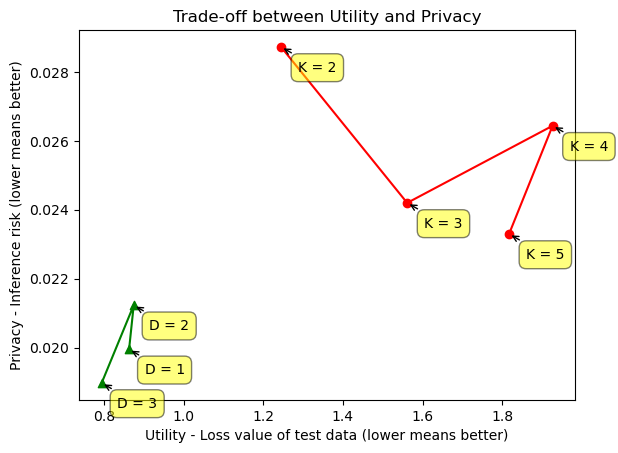

In [17]:
keys = []
for k in k_list:
    key = f"K = {k}"
    keys.append(key)
    plt.scatter(test_accs_nhs[key], inference_risk_nhs[key], label=key, marker='o', c='r')
for d in degrees:
    key = f"D = {d}"
    keys.append(key)
    plt.scatter(test_accs_syb[key], inference_risk_syn[key], label=key, marker = "^", c='g')
plt.plot(test_accs_nhs.values(), inference_risk_nhs.values(), c='r')
plt.plot(test_accs_syb.values(), inference_risk_syn.values(), c='g')
for label, x, y in zip(keys, list(test_accs_nhs.values()) + list(test_accs_syb.values()), list(inference_risk_nhs.values()) + list(inference_risk_syn.values())):
    plt.annotate(
        label,
        xy=(x, y), xytext=(40, -20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.title("Trade-off between Utility and Privacy")
plt.xlabel("Utility - Loss value of test data (lower means better)")
plt.ylabel("Privacy - Inference risk (lower means better)")
plt.show()

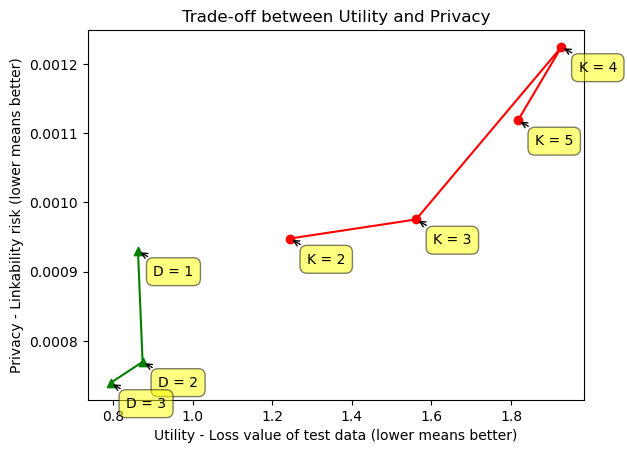

In [20]:
keys = []
for k in k_list:
    key = f"K = {k}"
    keys.append(key)
    plt.scatter(test_accs_nhs[key], linkability_risk_nhs[key], label=key, marker='o', c='r')
for d in degrees:
    key = f"D = {d}"
    keys.append(key)
    plt.scatter(test_accs_syb[key], linkability_risk_syn[key], label=key, marker = "^", c='g')
plt.plot(test_accs_nhs.values(), linkability_risk_nhs.values(), c='r')
plt.plot(test_accs_syb.values(), linkability_risk_syn.values(), c='g')
for label, x, y in zip(keys, list(test_accs_nhs.values()) + list(test_accs_syb.values()), list(linkability_risk_nhs.values()) + list(linkability_risk_syn.values())):
    plt.annotate(
        label,
        xy=(x, y), xytext=(40, -20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.title("Trade-off between Utility and Privacy")
plt.xlabel("Utility - Loss value of test data (lower means better)")
plt.ylabel("Privacy - Linkability risk (lower means better)")
plt.show()